In [8]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# 引入准备好的数据
%run 第五周测试1H.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


# 准备一个模型评估函数

In [21]:
def evaluate_model(y_true, y_pred, y_prob):
    metrics = {
        '准确率': accuracy_score(y_true, y_pred),
        '精确率': precision_score(y_true, y_pred),
        '召回率': recall_score(y_true, y_pred),
        'F1分数': f1_score(y_true, y_pred),
        #'AUC分数': roc_auc_score(y_true, y_prob[:, 1])
    }
    # Fixed：适配xgb原生的输出格式，如果是一维数组（XGBoost原生），直接用；如果是二维（sklearn），取第2列
    # 用上面的方法可以使用sklearn的XGB
    if y_prob is not None:
        if len(y_prob.shape) == 2:  # sklearn接口的输出（n_samples, 2）
            metrics['AUC分数'] = roc_auc_score(y_true, y_prob[:, 1])
        else:  # XGBoost原生接口的输出（n_samples,）
            metrics['AUC分数'] = roc_auc_score(y_true, y_prob)
    
    print("模型评估结果：")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

# Bagging --- RandomForest ---- GridSearch调参

In [10]:
param_grid = {
    'criterion': ['gini', 'entropy'],  # 新增：特征选择准则
    'n_estimators': [100, 150, 200],  # 决策树数量
    'max_depth': [8, 12, None],  # 树最大深度
    'min_samples_split': [2, 4],  # 节点分裂最小样本数
    'min_samples_leaf': [1, 2],  # 叶节点最小样本数
    'max_features': ['sqrt'],  # 每棵树使用的特征比例
    'bootstrap': [True]
}

In [11]:
base_bagging = RandomForestClassifier(random_state = 42, n_jobs = -1)

grid_search = GridSearchCV(
    estimator = base_bagging,
    param_grid = param_grid,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True], 'criterion': ['gini', 'entropy'], 'max_depth': [8, 12, ...], 'max_features': ['sqrt'], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,150


,n_estimators,150
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
best_bagging = grid_search.best_estimator_
y_pred_bagging = best_bagging.predict(X_test)
y_prob_bagging = best_bagging.predict_proba(X_test)
bagging_metrics = evaluate_model(y_test, y_pred_bagging, y_prob_bagging)

模型评估结果：
准确率: 0.8429
精确率: 0.8148
召回率: 0.8706
F1分数: 0.8418
AUC分数: 0.9219


# Boosting --- Xgboost

In [14]:
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.08,
    'max_depth': 7,
    'n_estimators': 180,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    'reg_alpha': 0.2,
    'reg_lambda': 0.2,
    'gamma': 0.1,
    'random_state': 42,
    'eval_metric': 'auc',
    'silent': 1
}

In [15]:
# 转换格式
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [16]:
watchlist = [(dtest, 'val'), (dtrain, 'train')]

In [17]:
model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=200,  # 最大迭代次数
    evals=watchlist,
    early_stopping_rounds=10,  # 早停阈值
    verbose_eval=10  # 每10轮输出一次评估结果
)

[0]	val-auc:0.86482	train-auc:0.89279
[10]	val-auc:0.90271	train-auc:0.93296
[20]	val-auc:0.90926	train-auc:0.94291
[30]	val-auc:0.91502	train-auc:0.95045
[40]	val-auc:0.91826	train-auc:0.95624


d:\anaconda3\envs\AI_Env\lib\site-packages\xgboost\callback.py:386: UserWarning: [03:52:50] WARNING: D:\bld\xgboost-split_1768313916136\work\src\learner.cc:790: 
Parameters: { "n_estimators", "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	val-auc:0.92055	train-auc:0.96260
[60]	val-auc:0.92338	train-auc:0.96740
[70]	val-auc:0.92491	train-auc:0.97047
[80]	val-auc:0.92623	train-auc:0.97352
[90]	val-auc:0.92621	train-auc:0.97653
[100]	val-auc:0.92630	train-auc:0.97893
[110]	val-auc:0.92663	train-auc:0.98160
[120]	val-auc:0.92629	train-auc:0.98401
[130]	val-auc:0.92646	train-auc:0.98576
[140]	val-auc:0.92599	train-auc:0.98751
[150]	val-auc:0.92608	train-auc:0.98864
[160]	val-auc:0.92597	train-auc:0.99044
[170]	val-auc:0.92606	train-auc:0.99171
[180]	val-auc:0.92593	train-auc:0.99248
[190]	val-auc:0.92568	train-auc:0.99351
[199]	val-auc:0.92533	train-auc:0.99434


In [23]:
y_pred_xgb = model.predict(dtest)
y_pred_xgb = (y_pred_xgb > 0.5).astype(int)  # 概率转类别（二分类阈值0.5）
y_prob_xgb = model.predict(dtest)  # 预测概率

xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_prob_xgb)

模型评估结果：
准确率: 0.8549
精确率: 0.8284
召回率: 0.8799
F1分数: 0.8533
AUC分数: 0.9253


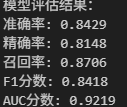

对比可以看出Xgboost性能好一些，训练也比较快